# OpenStreetMap beginner's tutorial

Written by Emma Roscow, 31st July 2021 for Omdena Silicon Valley chapter

Best read in conjunction with Google Slides presentation

For questions, contact me at roscowemma@gmail.com


In [ ]:
# Install and import OSMnx
!apt install python3-rtree
!pip install osmnx
import osmnx as ox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


# Creating maps and visualisations with OSMnx
### Simple visualisation of road networks

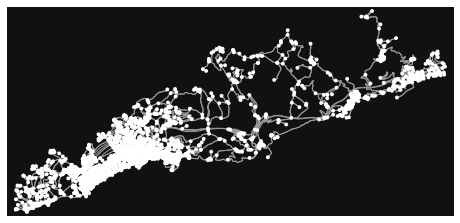

In [ ]:
# Visualise map of a city
city = "Sitges"
G = ox.graph_from_place(city)
ox.plot_graph(G);

# If there are several cities in the world with the same name, you can be more specific, e.g. "Sitges, Cataluña"
# G is a graph, defined by edges (road segments) and nodes (intersections). In this visualisation you can see edges represented as lines and nodes as circles
# Exercise for you to try: load a few cities/towns, some big, some small. Note the difference in how long it takes to load them!

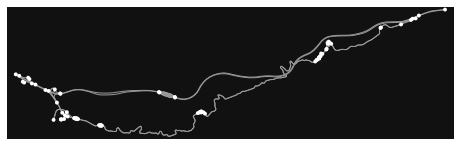

In [ ]:
# Visualise main roads of a city
city = "Sitges"
G = ox.graph_from_place(city, custom_filter='["highway"~"motorway|trunk|primary|secondary"]')
ox.plot_graph(G);

# Roads are called highways, and every highway is categorised according to how big and important it is. See more details on the wiki: https://wiki.openstreetmap.org/wiki/Key:highway

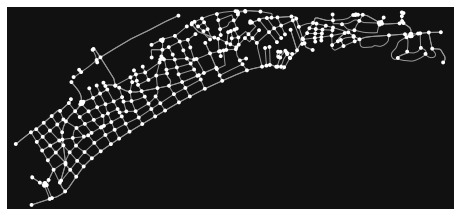

In [ ]:
# Visualise residential roads of a city
city = "Sitges"
G = ox.graph_from_place(city, custom_filter='["highway"~"residential"]')
ox.plot_graph(G);

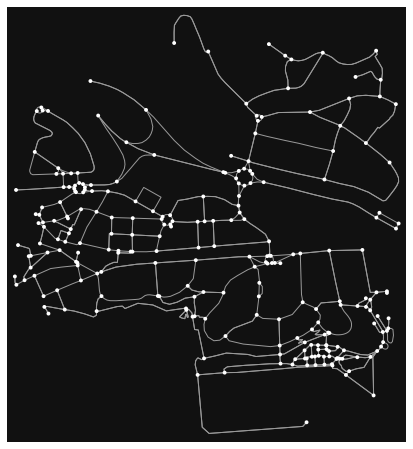

In [ ]:
# Visualise map by coordinates
lat = 41.23804005603409
long = 1.8216576966623874
distance_in_metres = 500
G = ox.graph_from_point((lat, long), dist=distance_in_metres)
ox.plot_graph(G);

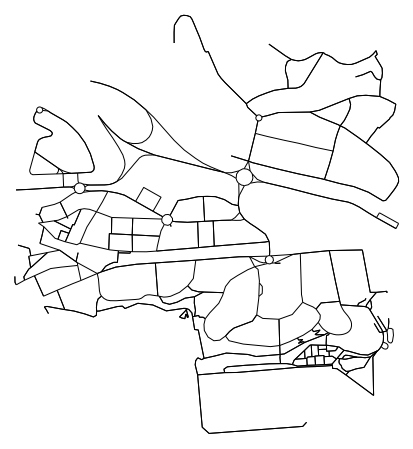

In [ ]:
# Improve aesthetics
ox.plot_graph(G, bgcolor="w", edge_color="k", node_size=0);

# Handling roads as graphs and polygons
### Examining the graph

In [ ]:
# Convert graph to GeoDataFrame
G = ox.graph_from_point((lat, long), dist=distance_in_metres)
nodes, edges = ox.graph_to_gdfs(G)
edges.head()

# OSMnx relies on several other popular geospatial libraries, mostly Networkx and GeoPandas.
# To examine the individual nodes and edges of the graph, it is easiest to convert it to a GeoDataFrame.
# Each row of the GeoDataFrame is an edge (road or segment of a road). It is defined by a node at one end (u) and a node at the other end (v).
# Where two rows share a u (or a v), they intersect at that node u (or v). Occasionally two road segments could start and end at the same place; when this happens, they keys will be different

osmid  ...  tunnel
u         v          key                                    ...        
300008618 300008677  0                            27328834  ...     NaN
          383894531  0    [878974900, 878974899, 27328836]  ...     NaN
300008677 300008900  0                            27328837  ...     NaN
          7302438537 0              [128799012, 782127164]  ...     NaN
300008681 7302438515 0                           275262458  ...     NaN

[5 rows x 14 columns]

In [ ]:
# Examine highway types
edges["highway"].value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


residential            62
footway                18
secondary              16
pedestrian              8
service                 6
[residential, path]     2
path                    2
steps                   2
Name: highway, dtype: int64

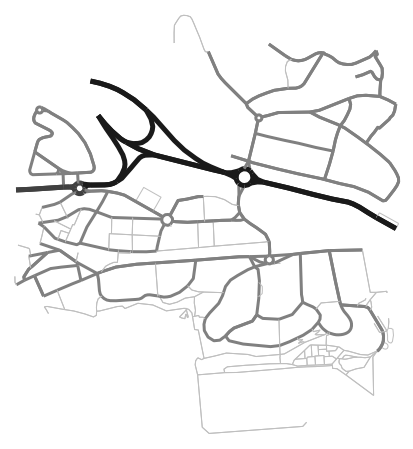

In [ ]:
# Improve aesthetics more
edge_color = [[0.1, 0.1, 0.1] if 'secondary' in e
              else  [0.25, 0.25, 0.25] if 'tertiary' in e
              else [0.5, 0.5, 0.5] if 'residential' in e
              else [0.75, 0.75, 0.75] 
              for e in edges['highway']]
linewidth = [5 if ('secondary' in e) | ('tertiary' in e)
             else 3 if 'residential' in e
             else 1
             for e in edges['highway']]
ox.plot_graph(G, bgcolor="w", edge_color=edge_color, edge_linewidth=linewidth, node_size=0);

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


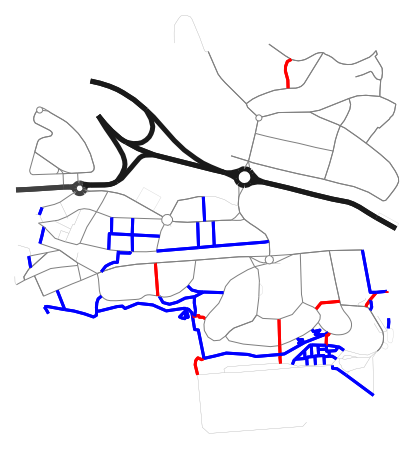

In [ ]:
# Highlight relevant features
edge_color = [[0.1, 0.1, 0.1] if 'secondary' in e
              else  [0.25, 0.25, 0.25] if 'tertiary' in e
              else [0.5, 0.5, 0.5] if 'residential' in e
              else "b" if ('footway' in e) | ('pedestrian' in e)
              else "r" if 'steps' in e
              else [0.75, 0.75, 0.75] 
              for e in edges['highway']]
linewidth = [5 if ('secondary' in e) | ('tertiary' in e)
             else 1 if 'residential' in e
             else 3 if ('footway' in e) | ('pedestrian' in e) | ('steps' in e)
             else 0.25
             for e in edges['highway']]
ox.plot_graph(G, bgcolor="w", edge_color=edge_color, edge_linewidth=linewidth, node_size=0);

### Roads as geometries

In [ ]:
# Examine graph edges again
edges.head()

osmid  ...  tunnel
u         v          key                                    ...        
300008618 300008677  0                            27328834  ...     NaN
          383894531  0    [878974900, 878974899, 27328836]  ...     NaN
300008677 300008900  0                            27328837  ...     NaN
          7302438537 0              [128799012, 782127164]  ...     NaN
300008681 7302438515 0                           275262458  ...     NaN

[5 rows x 14 columns]

LINESTRING (1.8183305 41.2406634, 1.8185432 41.2404693, 1.8187466 41.240307, 1.8190116 41.240132, 1.8191073 41.2400839, 1.819189 41.2400513, 1.8191948 41.2400481)


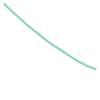

In [ ]:
# Linestring
print(edges["geometry"].iloc[1])
edges["geometry"].iloc[1]

# Here we retrieve the column "geometry" from the GeoDataFrame "edges", and the first row of the column, indexed as 0
# Printing it as text shows that it consists of a series of latitude and longitude points
# Visualising it shows it is a two-dimensional line, a data structure called LINESTRING, commonly used in other libraries such as Networkx and Shapely

In [ ]:
# Examine graph nodes
nodes.head()

# Nodes have much fewer attributes. They have a latitude and longitude (x and y), and are defined by a data structure called POINT

,y,x,street_count,highway,geometry
osmid,,,,,
300008618,41.240663,1.818331,3,NaN,POINT (1.81833 41.24066)
300008677,41.239142,1.818903,3,NaN,POINT (1.81890 41.23914)
300008681,41.239014,1.817272,3,NaN,POINT (1.81727 41.23901)
300008825,41.236637,1.817073,3,NaN,POINT (1.81707 41.23664)
300008829,41.236863,1.817802,3,NaN,POINT (1.81780 41.23686)


In [ ]:
# Find distance from roads to a point

# Specify the point
from shapely.geometry import Point
I_am_here = Point(long, lat)

# Calculate the distance from the point to every road in the graph (in degrees)
for _, road in edges.iterrows():
  print(road["name"], road["geometry"].distance(I_am_here))

# Note that the distance is given in degrees. For small distances you can approximately convert this to Euclidean distance by multiplying by the Earth's radius (see next cell)
# For more precise measurements, use the Haversine formula

Carretera dels Molins 0.002889094646970213
nan 0.0031777508616391194
Carretera de les Costes 0.0023514649910004394
Carretera de les Costes 0.002967480466165764
Carretera de les Costes 0.004328434020833219
Carretera de les Costes 0.004492950654006128
nan 0.004727926747468398
Avinguda de Balmins 0.004030997893560254
Avinguda de Balmins 0.003506495391248665
Carrer Pompeu Fabra 0.003506495391248665
Carrer de Ramon Planes 0.003506495391248665
Avinguda de Balmins 0.0033761254815168054
Carrer d'Emerència Roig i Raventos 0.0007853416260759346
Carrer d'Emerència Roig i Raventos 0.0006893088670018739
Carrer d'Emerència Roig i Raventos 0.0014525468004359106
Carrer d'Emerència Roig i Raventos 0.0014525468004359106
Carrer d'Emerència Roig i Raventos 0.0006893088670018739
Carrer de la Marina d'Aiguadolç 0.0027133706214998634
Carrer de la Marina d'Aiguadolç 0.002057386175609708
nan 0.0020175777447967737
Carrer de la Riera d'Aiguadolç 0.0010825203796676474
Carrer de la Riera d'Aiguadolç 0.001177344632

In [ ]:
# Find nearest road to specified point

road_names, road_distances = [], []

# Iterate over graph edges
for _, road in edges.iterrows():
  
  # Store name of road
  road_names.append(road["name"])
  
  # Calculate distance and store
  road_distances.append(road["geometry"].distance(I_am_here))

index_of_closest_road = road_distances.index(min(road_distances))
print("Closest road is called:", road_names[index_of_closest_road])
print("Distance from specified point in metres is:", road_distances[index_of_closest_road] * 111139)

# Note that the last line multiplies by 111,139 (the radius of the Earth in metres) to convert degrees to metres

Closest road is called: Carrer de la Devesa
Distance from specified point in metres is: 20.88332374804808


### More on geometries

In [ ]:
# Polygons: get footprints of buildings
buildings = ox.geometries_from_point((lat, long), tags={'building': True}, dist=200)
buildings.head()

# Buildings are one example, but there are many features of OSM with other tags too. See the wiki for more: https://wiki.openstreetmap.org/wiki/Map_features

nodes  ... website
element_type osmid                                                         ...        
way          128799000  [1422370837, 5263354322, 1422370828, 142237082...  ...     NaN
             317530383  [3238055158, 3238055118, 3238055123, 323805526...  ...     NaN
             317530387  [3238054927, 3238054907, 3238054903, 323805490...  ...     NaN
             317530388  [3238055275, 3238055133, 3238055134, 323805526...  ...     NaN
             317530389  [3238055075, 3238055063, 3238055064, 323805495...  ...     NaN

[5 rows x 11 columns]

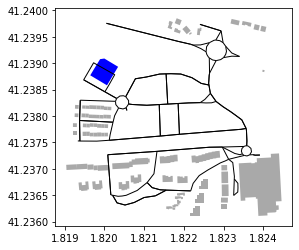

In [ ]:
# Plot streets and buildings
G = ox.graph_from_point((lat, long), dist=200)
nodes, edges = ox.graph_to_gdfs(G)
ax = edges.plot(linewidth=1, edgecolor="black")
color = ["blue" if shop=="supermarket"
        else "darkgrey" for shop in buildings["shop"]]
buildings.plot(ax=ax, facecolor=color);

In [ ]:
# Calculate whether a point is in a building
for building in buildings["geometry"]:
  print(building.contains(Point(lat, long)))

# This might be useful for the earthquake project: the buildings are one example of polygons, but you can define you own polygons too which might correspond to dangerous or devastated areas in an earthquake, and identify points which are inside your polygon

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


# Roads as graphs: path-finding

[671533202, 1582895050, 2242803918, 1915135881, 1915135883, 671533308, 506301362, 506301351, 2241677726, 300008937, 300008940, 300008929, 2828839668, 2828839670, 663771745, 663771747, 663771764, 1582895016, 663771796, 663771856, 8694138003, 8270434737, 5550871782, 5550871772, 5550871785, 5550871749, 5550871759, 5550871787, 300008763, 300008762, 300008760, 300008749, 414041550, 472365998, 472366039, 1582534358, 420210354, 1582534348, 1582534355, 300008781, 1423001082, 1423001083, 1423001085, 300008683, 321827956, 321827952, 383894531, 300008900, 321827949, 300008898, 300008969, 300008971, 300008877, 300008879, 321828212, 7592880978, 1640619211, 8308467482, 1640619207, 1640624825, 321828204, 5435842008]


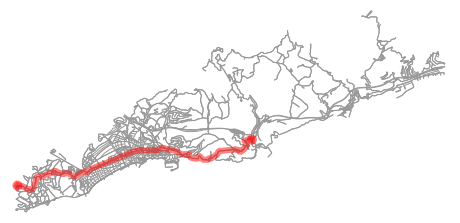

In [ ]:
# Find the shortest route between two points

G = ox.graph_from_place(city)

# Choose points of interest
A = (1.751086796668785, 41.22947805375013)
B = (1.8599452222140964, 41.24126065928708)

# Find nearest graph node for each POI
A_node = ox.distance.nearest_nodes(G, A[0], A[1])
B_node = ox.distance.nearest_nodes(G, B[0], B[1])

# Find shortest path between them
path = ox.distance.shortest_path(G, orig=A_node, dest=B_node)
print(path)  # The path that is returned is a list of edges, i.e. road segments, defined by their osmid

# Plot shortest path
ox.plot_graph_route(G, path, route_linewidth=6, node_size=0, bgcolor="w");

[671533202, 1582895050, 2242803918, 1915135881, 1915135883, 671533308, 506301362, 506301351, 2241677726, 300008937, 300008940, 300008929, 2828839668, 2828839670, 663771745, 663771747, 663771764, 1582895016, 663771796, 663771856, 8694138003, 8270434737, 5550871782, 5550871772, 5550871785, 5550871749, 5550871759, 5550871787, 300008763, 300008762, 300008760, 300008749, 414041550, 472365998, 472366039, 1582534358, 420210354, 1582534348, 1582534355, 300008781, 1423001082, 1423001083, 1423001085, 300008683, 321827956, 321827952, 383894531, 300008900, 321827949, 300008898, 300008969, 300008971, 300008877, 300008879, 321828212, 7592880978, 1640619211, 8308467482, 1640619207, 1640624825, 321828204, 5435842008]


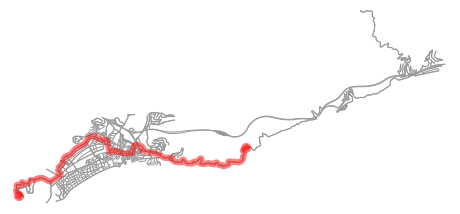

In [ ]:
# Find the fastest route by driving

G = ox.graph_from_place(city, network_type="drive") # Note that this is different from the above! It excludes pedestrian roads and other highway types which cannot be driven along

# Choose points of interest
A = (1.751086796668785, 41.22947805375013)
B = (1.8599452222140964, 41.24126065928708)

# Find nearest graph node for each POI
A_node = ox.distance.nearest_nodes(G, A[0], A[1])
B_node = ox.distance.nearest_nodes(G, B[0], B[1])

# Find shortest path between them
path = ox.distance.shortest_path(G, orig=A_node, dest=B_node, weight="travel_time") # Note that this is different too: here, the edges are weighted according to travel_time, not distance which is the default
print(paths)

# Plot shortest path
ox.plot_graph_route(G, path, route_linewidth=6, node_size=0, bgcolor="w");

In [ ]:
# Apply custom attribute to graph edges
nodes, edges = ox.graph_to_gdfs(G)
edges["custom_att"] = [x for x in range(edges.shape[0])]
edges.head()

# This might be useful for the earthquake project in particular: you can assess how safe the edges (road segments) are and add this as an additional attribute

osmid  oneway  ... width custom_att
u         v          key                    ...                 
243462732 243462733  0    42368739   False  ...   NaN          0
          1606514835 0    42368739   False  ...   NaN          1
243462733 248454714  0    23029193    True  ...   NaN          2
          243462735  0    42368739   False  ...   NaN          3
          243462732  0    42368739   False  ...   NaN          4

[5 rows x 15 columns]

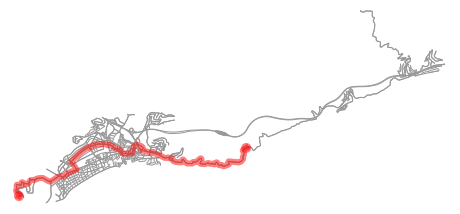

In [ ]:
# Optimise shortest path according to custom attribute
G_custom = ox.utils_graph.graph_from_gdfs(nodes, edges)
path = ox.distance.shortest_path(G_custom, orig=A_node, dest=B_node, weight="custom_att")

# Plot shortest path
ox.plot_graph_route(G_custom, path, route_linewidth=6, node_size=0, bgcolor="w");

# To use the custom attribute for path-finding, add the attribute to the GeoDataFrame (as in previous cell) and convert the GeoDataFrame to a graph (as in this cell)

In [ ]:
# Remove an edge

# Print the first 5 edges before removing any
nodes, edges = ox.graph_to_gdfs(G_custom)
print(edges.head())

# Remove the first edge by indexing its u and v
G_custom.remove_edge(243462732, 1606514835)
nodes, edges = ox.graph_to_gdfs(G_custom)
edges.head()

# You may wish to remove entire roads which have been destroyed or are unsuitable for emergency vehicles, for example

                               osmid  oneway  ... junction access
u          v          key                     ...                
243462732  1606514835 0     42368739   False  ...      NaN    NaN
1606514835 243462732  0     42368739   False  ...      NaN    NaN
           4011616250 0    398400621    True  ...      NaN    NaN
243462733  248454714  0     23029193    True  ...      NaN    NaN
           243462735  0     42368739   False  ...      NaN    NaN

[5 rows x 15 columns]


osmid  oneway  ... junction access
u          v          key                     ...                
1606514835 243462732  0     42368739   False  ...      NaN    NaN
           4011616250 0    398400621    True  ...      NaN    NaN
243462733  248454714  0     23029193    True  ...      NaN    NaN
           243462735  0     42368739   False  ...      NaN    NaN
           243462732  0     42368739   False  ...      NaN    NaN

[5 rows x 15 columns]

In [ ]:
# Plot an interactive map of the route
ox.folium.plot_route_folium(G, path, popup_attribute="maxspeed")

# Points of interest

In [ ]:
# Get nearby points of interest
ox.geometries.geometries_from_place(city, tags= {"amenity":["hospital", "clinic"]})
ox.geometries.geometries_from_place(city, tags= {"amenity":"school"})
ox.geometries.geometries_from_place(city, tags= {"amenity":"restaurant"})
ox.geometries.geometries_from_place(city, tags= {"emergency":True})

# These are a few examples of other points of interest on the map and their tags

amenity emergency  ... healthcare               source
element_type osmid                         ...                                
node         1582706917  clinic       yes  ...        NaN                  NaN
             7296670262  clinic       NaN  ...     clinic  gps;local knowledge

[2 rows x 6 columns]

# Land use

In [ ]:
# Find polygons for land use in Sitges
all_landuse = ox.geometries.geometries_from_place(city, tags={"landuse":True});
all_landuse.head()

geometry  ... leaf_type
element_type osmid                                                         ...          
way          154351777  POLYGON ((1.89815 41.25049, 1.89825 41.25044, ...  ...       NaN
             154355857  POLYGON ((1.92260 41.25948, 1.92251 41.25938, ...  ...       NaN
             180311342  POLYGON ((1.76838 41.23420, 1.76769 41.23379, ...  ...       NaN
             180311343  POLYGON ((1.76686 41.23221, 1.76633 41.23203, ...  ...       NaN
             180311345  POLYGON ((1.76914 41.23324, 1.76925 41.23314, ...  ...       NaN

[5 rows x 20 columns]

In [ ]:
# List all types of landuse and how many polygons there are of each
all_landuse["landuse"].value_counts()

forest            108
grass              37
residential        22
vineyard           18
railway            15
traffic_island     15
farmland           12
quarry              7
meadow              6
village_green       4
industrial          4
allotments          3
scrub               3
orchard             3
basin               3
cemetery            2
farmyard            1
Name: landuse, dtype: int64

In [ ]:
# Get polygons for each type of landuse, to be plotted later
G = ox.graph_from_place(city)
forest = ox.geometries.geometries_from_place(city, tags={"landuse":"forest"})
grass = ox.geometries.geometries_from_place(city, tags={"landuse":["grass", "meadow"]})
res = ox.geometries.geometries_from_place(city, tags={"landuse":"residential"})
farm = ox.geometries.geometries_from_place(city, tags={"landuse":["vineyard", "farmland", "farmyard"]})
industrial = ox.geometries.geometries_from_place(city, tags={"landuse":"industrial"});

In [ ]:
forest.head()

nodes  ... type
element_type osmid                                                         ...     
way          200216267  [2102106876, 2102106871, 2102106888, 210210687...  ...  NaN
             200350686  [2103407791, 2103407872, 2103407862, 210340787...  ...  NaN
             208988058  [2192384861, 2192384810, 2192384852, 219238482...  ...  NaN
             208989232  [2192398358, 2192398381, 2192398383, 219239837...  ...  NaN
             208990459  [2192436434, 2192437049, 2192436779, 210610663...  ...  NaN

[5 rows x 6 columns]

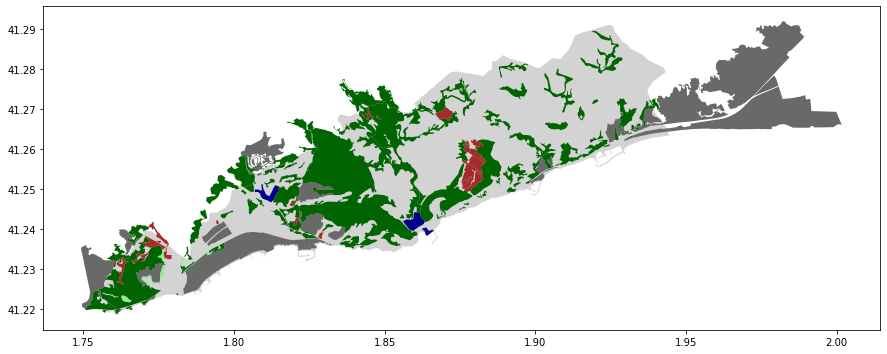

In [ ]:
# Plot land use

# Import matplotlib to create an axis onto which all polygons can be plotted
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

# Plot city polygon
city_polygon = ox.geocode_to_gdf(city)
city_polygon.plot(color="lightgrey", ax=ax)

# Plot each landuse type in different colours
res.loc[["way", "relation"], "geometry"].plot(color="dimgrey", ax=ax)
forest.loc[["way", "relation"], "geometry"].plot(color="darkgreen", ax=ax)
grass.loc[["way", "relation"], "geometry"].plot(color="lightgreen", ax=ax)
farm.loc[["way", "relation"], "geometry"].plot(color="brown", ax=ax)
industrial.loc[["way", "relation"], "geometry"].plot(color="darkblue", ax=ax);